# PROBLEM STATEMENT

*   In this project, I tried to detect/classify a chest disease from given X-ray chest data images each belongs to 4 classes: Healthy, Covid-19, Bacterial Pneumonia, Viral Pneumonia using Deep Learning Framework of Convolutional Neural Networks (CNN)
*   The dataset contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images. Each class contains 133 images.
<br>

*   Dataset Source:
*   https://github.com/ieee8023/covid-chestxray-dataset 
*   https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# IMPORT LIBRARIES AND VISUALIZE DATASET

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Training data directory
XRay_Directory = '/content/drive/My Drive/Colab Notebooks/Chest_X_Ray/train'

In [ ]:
# List the folders in the directory
os.listdir(XRay_Directory)

['3', '2', '1', '0']

In [ ]:
# Instantiate ImageDataGenerator (apply normalization and set 20% of the data for cross-validation)  
# Total number of images is 133*4 = 532 images (Training is 428 (80%) and validation is 104 (20%))
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
# Generate batch of tensor images for visualization purposes
images, labels = next(image_generator.flow_from_directory(directory=XRay_Directory))

Found 532 images belonging to 4 classes.


In [ ]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

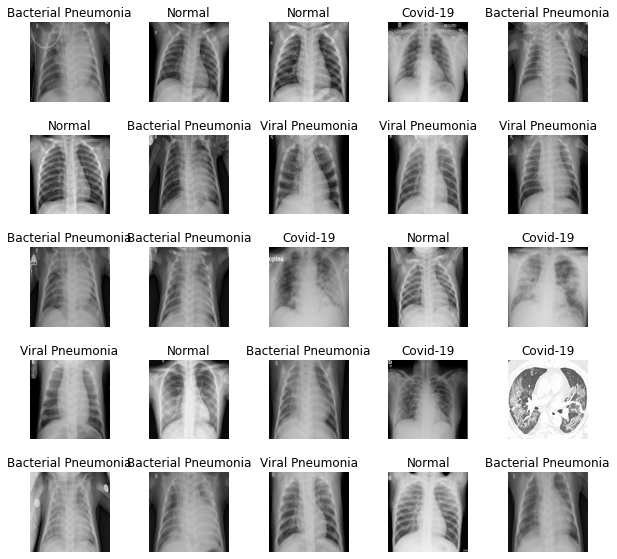

In [ ]:
# Let's show some images from this batch along with their corresponding labels
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(images[i])
    axes[i].set_title(label_names[np.argmax(labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# IMPORT RESNET MODEL WITH PRETRAINED WEIGHTS

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,\
Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# Download the ResNet50 model
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

In [ ]:
# freeze all the layers (except the last 10 that we want to modify) in the model
for layer in basemodel.layers[:-10]:
    layer.trainable=False

# BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
# Get the base model and add some other layers to adjust the model for our dataset
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel) 
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel) 
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6),
              metrics= ["accuracy"])

In [ ]:
# Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Generate batch of tensor images for both training and validation data
batch_size = 8

In [ ]:
train_generator = image_generator.flow_from_directory(
                                    directory=XRay_Directory, 
                                    target_size=(256,256),
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    subset="training")

Found 428 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(
                                    directory=XRay_Directory, 
                                    target_size=(256,256),
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=True,
                                    subset="validation")

Found 104 images belonging to 4 classes.


In [ ]:
# Fit the model
model.fit(train_generator,
          epochs = 30, 
          validation_data= val_generator, 
          callbacks=[earlystopping])

Epoch 1/30
54/54 [==============================] - 13s 190ms/step - loss: 0.9086 - accuracy: 0.6574 - val_loss: 5.0524 - val_accuracy: 0.2500
Epoch 2/30
54/54 [==============================] - 9s 175ms/step - loss: 0.4549 - accuracy: 0.8403 - val_loss: 0.7367 - val_accuracy: 0.7019
Epoch 3/30
54/54 [==============================] - 9s 175ms/step - loss: 0.3337 - accuracy: 0.8606 - val_loss: 0.9244 - val_accuracy: 0.6442
Epoch 4/30
54/54 [==============================] - 9s 172ms/step - loss: 0.3413 - accuracy: 0.8852 - val_loss: 0.7198 - val_accuracy: 0.7308
Epoch 5/30
54/54 [==============================] - 9s 172ms/step - loss: 0.2842 - accuracy: 0.8961 - val_loss: 1.0223 - val_accuracy: 0.7019
Epoch 6/30
54/54 [==============================] - 9s 174ms/step - loss: 0.3564 - accuracy: 0.8569 - val_loss: 0.4349 - val_accuracy: 0.8558
Epoch 7/30
54/54 [==============================] - 9s 173ms/step - loss: 0.2978 - accuracy: 0.8831 - val_loss: 0.7347 - val_accuracy: 0.7308
Epoch

# EVALUATE MODEL

In [ ]:
# take the metrics into df
losses = pd.DataFrame(model.history.history)

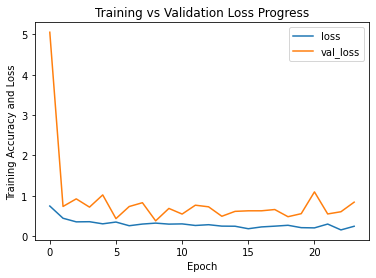

In [ ]:
losses[['loss','val_loss']].plot()
plt.title('Training vs Validation Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.show()

In [ ]:
# Apply the image generation into the test data
test_directory = '/content/drive/My Drive/Colab Notebooks/Chest_X_Ray/test'

test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=batch_size, 
                                              directory=test_directory, 
                                              shuffle=True, 
                                              target_size=(256,256), 
                                              class_mode='categorical')

Found 40 images belonging to 4 classes.


In [ ]:
# Look at the accuracy of test data
evaluate = model.evaluate(test_generator)
print('Accuracy of Test Data: {}'.format(evaluate[1]))

5/5 [==============================] - 1s 165ms/step - loss: 1.3538 - accuracy: 0.6500
Accuracy of Test Data: 0.6499999761581421
